## Tutorial number 1
### Working with ethoscope data
The tutorial will guide you through loading data, visualisation and plotting using the common sleep functions

## 1. Load the dummy dataset

In [1]:
import ethoscopy as etho
import pandas as pd

In [2]:
# This tutorial requires version 1.1.7 or greater
etho.__version__

'2.0 Demo'

In [3]:
# This creates the behavpy object, combining your data and metadata into a behavpy dataframe (remember to keep them in this order data, metadata - otherwise it will cause problems later down the line)
# The parameter check is used to see if the ids of the specimen in the data match those in the metadata. It also removes some columns that are not needed now you've downloaded the data
# Canvas specifies which plotting library you want to use. The choice is between plotly (default) and the matplotlib-frontend seaborn. 
# plotly allows to output interactive graphs but it's a bit more cumbersome to use and heavier in size. Seaborn / matplotlib is more of a standard, lighter and beautiful but only outputs static plots
# Try this notebook using both canvases to see the differences

d = pd.read_pickle('/home/lab/Desktop/ethoscopy/tutorial_notebook/response_d.pkl')
m = pd.read_pickle('/home/lab/Desktop/ethoscopy/tutorial_notebook/response_m.pkl')
df = etho.behavpy(d, m, check = True, canvas = 'seaborn')
df.meta['exp'] = df.meta['odour'] + '-' + df.meta['rest']
fargs =  ['air-first day', 'air-second day', 'air-third day', 'air-fourth day', 'air-fifth day', '5% AA-first day', '5% AA-second day', '5% AA-third day', '5% AA-fourth day', '5% AA-fifth day']
df.canvas

'seaborn'

/home/lab/Desktop/ethoscopy/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 80.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/lab/Desktop/ethoscopy/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 65.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_34545/3607412155.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


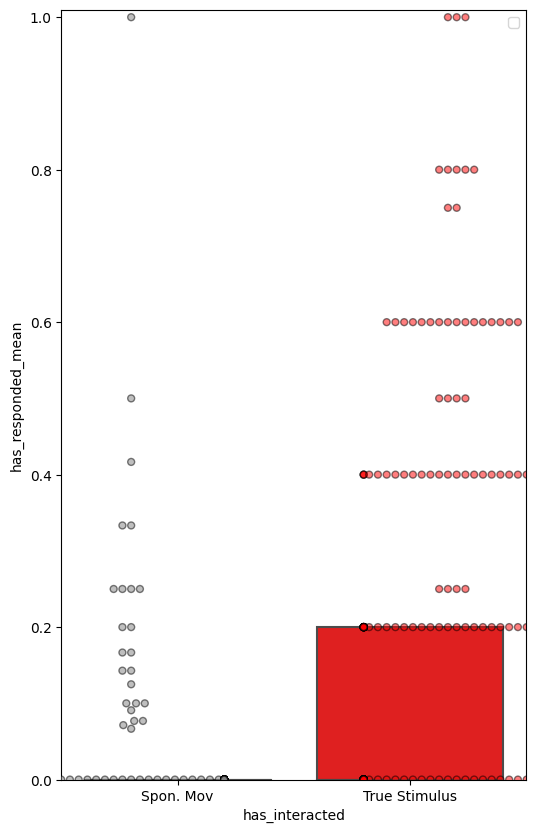

In [4]:
fig, stats_s = df.plot_response_quantify(title = '')
fig.show()

/tmp/ipykernel_34545/450043246.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


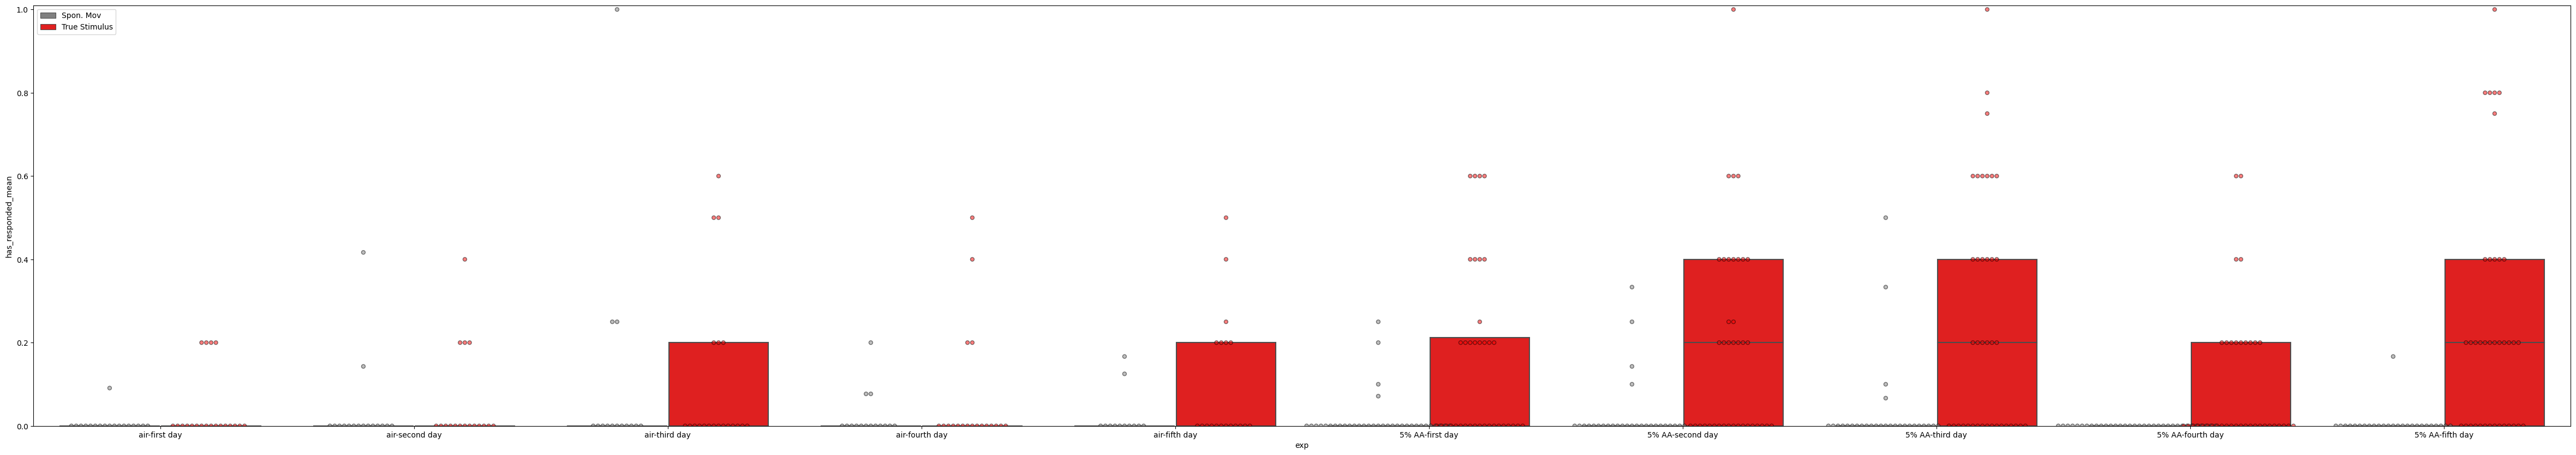

In [6]:
fig, stats_s = df.plot_response_quantify(facet_col = 'exp', facet_arg = fargs, title = '')
fig.show()

In [ ]:
stats_s

,has_interacted,has_responded_mean,has_responded_std,exp
id,,,,
2024-02-18_18-12-56_035ceb|10,Spon. Mov,0.0,0.000000,5% AA-fifth day
2024-02-18_18-09-42_0317e0|09,True Stimulus,0.2,0.447214,5% AA-fifth day
2024-02-18_18-09-42_0317e0|08,True Stimulus,0.0,0.000000,5% AA-fifth day
2024-02-18_18-09-42_0317e0|07,Spon. Mov,0.0,0.000000,5% AA-fifth day
2024-02-18_18-09-42_0317e0|07,True Stimulus,0.8,0.447214,5% AA-fifth day
...,...,...,...,...
2024-02-16_10-47-45_03318f|08,True Stimulus,0.0,0.000000,air-third day
2024-02-16_10-47-45_03318f|09,True Stimulus,0.0,0.000000,air-third day
2024-02-16_10-47-45_03318f|10,True Stimulus,0.2,0.447214,air-third day


In [ ]:
stats_s[stats_s['exp'] == 'air-first day'][stats_s[stats_s['exp'] == 'air-first day']['has_interacted'] == 'True Stimulus']

,has_interacted,has_responded_mean,has_responded_std,exp
id,,,,
2024-02-13_17-17-52_03318f|02,True Stimulus,0.2,0.447214,air-first day
2024-02-13_17-17-52_03318f|03,True Stimulus,0.0,0.000000,air-first day
2024-02-13_17-17-52_03318f|04,True Stimulus,0.0,0.000000,air-first day
2024-02-13_17-17-52_03318f|05,True Stimulus,0.2,0.447214,air-first day
2024-02-13_17-17-52_03318f|06,True Stimulus,0.0,0.000000,air-first day
2024-02-13_17-17-52_03318f|07,True Stimulus,0.2,0.447214,air-first day
2024-02-13_17-17-52_03318f|08,True Stimulus,0.0,0.000000,air-first day
2024-02-13_17-17-52_03318f|09,True Stimulus,0.0,0.000000,air-first day
2024-02-13_17-17-52_03318f|10,True Stimulus,0.0,0.000000,air-first day


In [ ]:
df = etho.behavpy(d, m, check = True, canvas = 'plotly')
df.meta['exp'] = df.meta['odour'] + '-' + df.meta['rest']
fig, stats_p = df.plot_response_quantify(facet_col = 'exp', facet_arg = fargs, title = '')
fig.show()

In [ ]:
stats_p

,air-first day Spon. Mov,air-first day,air-second day Spon. Mov,air-second day,air-third day Spon. Mov,air-third day,air-fourth day Spon. Mov,air-fourth day,air-fifth day Spon. Mov,air-fifth day,5% AA-first day Spon. Mov,5% AA-first day,5% AA-second day Spon. Mov,5% AA-second day,5% AA-third day Spon. Mov,5% AA-third day,5% AA-fourth day Spon. Mov,5% AA-fourth day,5% AA-fifth day Spon. Mov,5% AA-fifth day
0,0.0,0.0,0.000000,0.2,0.00,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.100000,0.00,0.0,0.0,0.0,1.00
1,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.000000,0.20,0.000000,0.00,0.000000,0.00,0.066667,0.00,0.0,0.0,0.0,0.00
2,0.0,0.0,0.000000,0.0,0.25,0.2,0.076923,0.2,0.125000,0.00,0.000000,0.20,0.000000,0.25,0.000000,0.00,0.0,0.0,0.0,0.00
3,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.20,0.000000,0.25,0.000000,1.00,0.0,0.0,0.0,0.80
4,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.40,0.250000,0.00,0.000000,0.00,0.0,0.2,0.0,0.00
5,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.40,0.000000,0.60,0.0,0.2,0.0,0.75
6,0.0,0.0,0.000000,0.2,0.25,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.60,0.000000,0.00,0.000000,0.20,0.0,0.0,0.0,0.00
7,0.0,0.0,0.000000,0.0,0.00,0.0,0.076923,0.0,0.166667,0.00,0.000000,0.40,0.000000,0.40,0.000000,0.40,0.0,0.0,0.0,0.40
8,0.0,0.2,0.000000,0.2,0.00,0.0,0.000000,0.0,0.000000,0.40,0.000000,0.25,0.000000,0.20,0.333333,0.75,0.0,0.2,0.0,0.80
9,0.0,0.0,0.000000,0.4,0.00,0.6,0.000000,0.2,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.0,0.2,0.0,0.20
